In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import emoji
import jaconv
import math

In [2]:
cd ../

C:\Users\akite\OneDrive\デスクトップ\source code\twitter-compe


In [32]:
train_df = pd.read_csv('./data/preprosessing_train.csv')

In [33]:
X_df_train = train_df[["is_url","is_location","num_emoji","num_reply","num_hash","text_length","num_kusa","is_date","is_time","text_del_one"]]
Y_df_train = train_df["flg"].astype(np.int64)
X_train =  X_df_train.values
y_train = Y_df_train.values
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=0.8, random_state=1)


In [34]:
X_df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20285 entries, 0 to 20284
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_url        20285 non-null  float64
 1   is_location   20285 non-null  float64
 2   num_emoji     20285 non-null  float64
 3   num_reply     20285 non-null  float64
 4   num_hash      20285 non-null  float64
 5   text_length   20285 non-null  float64
 6   num_kusa      20285 non-null  float64
 7   is_date       20285 non-null  float64
 8   is_time       20285 non-null  float64
 9   text_del_one  20280 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.5+ MB


In [35]:
#文字カラムに対する欠損値削除
X_train_del_one = X_train[:,9]
for idx in range(len(X_train_del_one)):
    if type(X_train_del_one[idx]) is float:
        print(X_train_del_one[idx])
        X_train_del_one[idx] = " " 

X_valid_del_one = X_valid[:,9]
for idx in range(len(X_valid_del_one)):
    if type(X_valid_del_one[idx]) is float:
        print(X_valid_del_one[idx])
        X_valid_del_one[idx] = " " 

nan
nan
nan
nan
nan


In [36]:
#単語ベクトル化
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
cv = TfidfVectorizer()
X_train_cv = cv.fit_transform(X_train_del_one)
X_valid_cv = cv.transform(X_valid_del_one)

In [37]:
#特徴量配列
X_train_feat = X_train[:,:8]
X_valid_feat = X_valid[:,:8]
X_train_feat.shape

(16228, 8)

In [38]:
#特徴量標準化
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
X_train_feat_ss = ss.fit_transform(X_train_feat)
X_valid_feat_ss = ss.transform(X_valid_feat)

In [39]:
#文字配列と特徴量の配列を結合する
X_train = np.concatenate([X_train_cv.toarray(),X_train_feat_ss],1)
X_valid = np.concatenate([X_valid_cv.toarray(),X_valid_feat_ss],1)

In [40]:
#型変換
X_train = X_train.astype(np.float64)
X_valid = X_valid.astype(np.float64)

In [41]:
#スパース配列に変換
from scipy.sparse import csr_matrix
X_train_csr = csr_matrix(X_train)
X_valid_csr = csr_matrix(X_valid)

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score ,precision_score, recall_score,f1_score
import seaborn as sns
def result_heatmap(Y_test,Y_pred):
    print("正解率:"+str(accuracy_score(Y_test, Y_pred)))
    print("適合率:"+str(recall_score(Y_test,Y_pred)))
    print("再現率:"+str(precision_score(Y_test,Y_pred)))
    print("F値:"+str(f1_score(Y_test, Y_pred)))  
    cm = confusion_matrix(Y_test, Y_pred)
    print(cm)
    sns.heatmap(cm,annot=True, cmap='Blues')

In [43]:
#lda
'''
from sklearn.decomposition import LatentDirichletAllocation as LDA

lda = LDA(n_components=50, max_iter=100, n_jobs=-1)
X_train_lda = lda.fit_transform(X_train_csr,y_train)
X_valid_lda = lda.transform(X_valid_csr)
'''

ValueError: Negative values in data passed to LatentDirichletAllocation.transform

In [52]:
from sklearn.decomposition import  TruncatedSVD 
pca =  TruncatedSVD(1000)
X_train_pca = pca.fit_transform(X_train_csr) 
X_valid_pca = pca.transform(X_valid_csr) 

In [53]:
print(X_train_pca.shape)
print(X_valid_pca.shape)

(16228, 1000)
(4057, 1000)


In [58]:
#randomforest
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=500,
                                    random_state=1)
model.fit(X_train_pca, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

正解率:0.9610549667241804
適合率:0.4664310954063604
再現率:0.9496402877697842
F値:0.6255924170616113
[[3767    7]
 [ 151  132]]


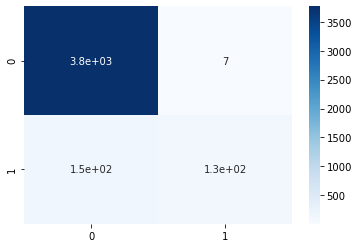

In [59]:
#普通にやると全部違う方に分類される
y_pred = model.predict(X_valid_pca)
result_heatmap(y_valid,y_pred)

In [19]:
#ロジスティック
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
pipe_lr = make_pipeline(
                       LogisticRegression(penalty="l2",C=100,random_state=1))
                       

正解率:0.958836578752773
適合率:0.696113074204947
再現率:0.7086330935251799
F値:0.7023172905525845
[[3693   81]
 [  86  197]]


c:\users\akite\onedrive\デスクトップ\source code\twitter-compe\venv\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


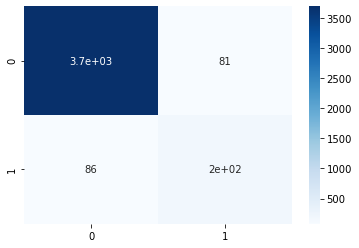

In [20]:
pipe_lr.fit(X_train_csr, y_train)
y_pred = pipe_lr.predict(X_valid_csr)
result_heatmap(y_valid,y_pred)

正解率:0.958836578752773
適合率:0.696113074204947
再現率:0.7086330935251799
F値:0.7023172905525845
[[3693   81]
 [  86  197]]


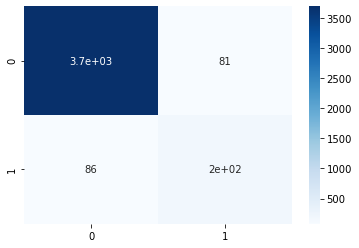

In [27]:
#KNN
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(3) # インスタンス生成。
knn.fit(X_train_csr, y_train)                 # モデル作成実行
y_pred = knn.predict(X_valid_csr)              # 予測実行
accuracy.append(f1_score(y_valid, y_pred)) # 精度格納
y_pred = pipe_lr.predict(X_valid_csr)
result_heatmap(y_valid,y_pred)


In [26]:
print(accuracy)

[0.6491557223264539, 0.6575963718820861, 0.6736401673640168, 0.6591928251121076, 0.6593406593406593, 0.6270022883295194, 0.6349206349206349, 0.6238532110091743, 0.6272727272727273, 0.6157407407407408, 0.6160919540229884, 0.6023529411764705, 0.6013986013986015, 0.5617433414043583, 0.565947242206235, 0.5533980582524272, 0.5507246376811594, 0.5260545905707197, 0.528395061728395, 0.515, 0.5223880597014926, 0.5125628140703518, 0.513715710723192, 0.5112781954887218, 0.513715710723192, 0.4832904884318766, 0.4873096446700508, 0.4635416666666667, 0.46907216494845355]
